# 프로젝트: 퍼스널 컬러 진단 - KNN 베이스코드

## 데이터
1. Cifer10 동물데이터: http://www.cs.toronto.edu/~kriz/cifar.html  
2. 직접 수집한 쿨톤 100장, 웜톤 100장  

## 목표
1. 우선 CS231에 나온 내용을 기반으로 cifer10 데이터셋을 KNN으로 분류하는 작업을 해보도록 하겠다!
2. 1단계를 적용하여 우리의 퍼스널컬러 데이터를 KNN으로 분류하는 작업을 해보자!
3. KNN + Skin Detection
4. KNN + Face Cropped
5. KNN + gradio

# 1. Cifer10 분류

## (1) 라이브러리 및 데이터 풀러오기

In [ ]:
import tensorflow as tf
import numpy as np

In [ ]:
# CIFAR-10 데이터셋 로드
(Xtr, Ytr), (Xte, Yte) = tf.keras.datasets.cifar10.load_data()

# 데이터 확인
print(Xtr.shape)  # (50000, 32, 32, 3)
print(Ytr.shape)  # (50000, 1)
print(Xte.shape)   # (10000, 32, 32, 3)
print(Yte.shape)   # (10000, 1)

170498071/170498071 [==============================] - 4s 0us/step
(50000, 32, 32, 3)
(50000, 1)
(10000, 32, 32, 3)
(10000, 1)


In [ ]:
#print(Xtr)

In [ ]:
print(Ytr)

[[6]
 [9]
 [9]
 ...
 [9]
 [1]
 [1]]


## (2) 데이터 전처리

In [ ]:
# 모든 이미지가 1차원 배열로 저장된다.
Xtr_rows = Xtr.reshape(Xtr.shape[0], 32 * 32 * 3) # Xtr_rows는 50000 x 3072 크기의 배열.
Xte_rows = Xte.reshape(Xte.shape[0], 32 * 32 * 3) # Xte_rows는 10000 x 3072 크기의 배열.

## (3) train, validation 분류하기

In [ ]:
# Xtr_rows, Ytr, Xte_rows, Yte 는 이전과 동일하게 갖고 있다고 가정하자.
# Xtr_rows 는 50,000 x 3072 행렬이었다.
Xval_rows = Xtr_rows[:1000, :] # 앞의 1000 개를 검증용으로 선택한다.
Yval = Ytr[:1000]
Xtr_rows = Xtr_rows[1000:, :] # 뒤쪽의 49,000 개를 학습용으로 선택한다.
Ytr = Ytr[1000:]

## (4) KNN(최접근이웃)

In [ ]:
class NearestNeighbor(object):
    def __init__(self):
        pass

    def train(self, X, y):
        """ X is N x D where each row is an example. Y is 1-dimension of size N """
        # nearest neighbor 분류기는 단순히 모든 학습 데이터를 기억해둔다.
        self.Xtr = X
        self.ytr = y

    def predict(self, X, k):
        """ X is N x D where each row is an example we wish to predict label for """
        num_test = X.shape[0]
        # 출력 type과 입력 type이 갖게 되도록 확인해준다.
        Ypred = np.zeros(num_test, dtype = self.ytr.dtype)

    # loop over all test rows
        for i in range(num_test):
        # i번째 테스트 이미지와 가장 가까운 학습 이미지를
        # L1 거리(절대값 차의 총합)를 이용하여 찾는다.
            distances = np.sum(np.abs(self.Xtr - X[i,:]), axis = 1)
            #distances = np.sqrt(np.sum(np.square(self.Xtr - X[i,:]), axis = 1))
            #min_index = np.argmin(distances) # 가장 작은 distance를 갖는 인덱스를 찾는다.
            #pred[i] = self.ytr[min_index] # 가장 가까운 이웃의 라벨로 예측

            indices = np.argsort(distances)  # 거리가 작은 순서대로 인덱스 정렬
            k_nearest_labels = self.ytr[indices[:k]]  # k개의 가장 가까운 이웃의 라벨
            unique, counts = np.unique(k_nearest_labels, return_counts=True)
            Ypred[i] = unique[np.argmax(counts)]  # 가장 많은 투표를 받은 라벨로 예측
        return Ypred

In [ ]:
# 검증 셋에서 가장 잘 동작하는 hyperparameter 들을 찾는다.
validation_accuracies = []
for k in [1, 3, 5, 10, 20, 50, 100]:

    # 특정 k 값을 정해서 검증 데이터에 대해 평가할 때 사용한다.
    nn = NearestNeighbor()
    nn.train(Xtr_rows, Ytr)
    # 여기서는 k를 input으로 받을 수 있도록 변형된 NearestNeighbor 클래스가 있다고 가정하자.
    Yval_predict = nn.predict(Xval_rows, k = k)
    acc = np.mean(Yval_predict == Yval)
    print('accuracy: %f' % (acc,))

    # 검증 셋에 대한 정확도를 저장해 놓는다.
    validation_accuracies.append((k, acc))

accuracy: 0.099237
accuracy: 0.099692
accuracy: 0.099476
accuracy: 0.099453
accuracy: 0.099738
accuracy: 0.099670
accuracy: 0.099609


In [ ]:
print(validation_accuracies)

[(1, 0.099237), (3, 0.099692), (5, 0.099476), (10, 0.099453), (20, 0.099738), (50, 0.09967), (100, 0.099609)]


-> 데이터 갯수에 비해 k값을 너무 작게 설정한 것 같아서 다시 수정해서 시도

In [ ]:
# 검증 셋에서 가장 잘 동작하는 hyperparameter 들을 찾는다.
validation_accuracies = []
for k in [100, 500, 2000, 4000, 8000]:

    # 특정 k 값을 정해서 검증 데이터에 대해 평가할 때 사용한다.
    nn = NearestNeighbor()
    nn.train(Xtr_rows, Ytr)
    # 여기서는 k를 input으로 받을 수 있도록 변형된 NearestNeighbor 클래스가 있다고 가정하자.
    Yval_predict = nn.predict(Xval_rows, k = k)
    acc = np.mean(Yval_predict == Yval)
    print('accuracy: %f' % (acc,))

    # 검증 셋에 대한 정확도를 저장해 놓는다.
    validation_accuracies.append((k, acc))

accuracy: 0.099609
accuracy: 0.100084
accuracy: 0.100414
accuracy: 0.100554
accuracy: 0.100498


In [ ]:
print(validation_accuracies)

[(100, 0.099609), (500, 0.100084), (2000, 0.100414), (4000, 0.100554), (8000, 0.100498)]


# 2. 퍼스널 컬러 분류: 베이스코드


## (1) 라이브러리 및 데이터 불러오기

In [ ]:
import tensorflow as tf
import numpy as np
import cv2
import os
import glob
from PIL import Image

In [ ]:
def load_images_from_directory(directory_path):
    image_paths = glob.glob(directory_path + '/*.jpg')  # 디렉토리 내의 모든 jpg 파일 경로 찾기
    image_paths.extend(glob.glob(directory_path + '/*.jpeg'))  # 디렉토리 내의 모든 jpeg 파일 경로 추가

    images = []
    for image_path in image_paths:
        image = Image.open(image_path)
        image_np = np.array(image)
        images.append(image_np)

    return images

- png파일의 경우 jpg, jfif, jepg 파일과 다른 알고리즘을 사용하여 shape이 동일하지 않는 오류가 뜨는 문제가 있었음. 그래서 모든 파일을 jpg, jepg로 바꾸어 해결함

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 모든 이미지 불러오기
directory_path = "/content/drive/MyDrive/four_seasons/사계절_연예인 이미지 데이터셋/prototype/쿨톤_jpg"  # 디렉토리 경로
directory_path2 = "/content/drive/MyDrive/four_seasons/사계절_연예인 이미지 데이터셋/prototype/웜톤_jpg"  # 디렉토리 경로
images = load_images_from_directory(directory_path)
images2 = load_images_from_directory(directory_path2)

length = len(images)
print(length)
print(len(images2))

# 이미지 리스트 합치기
images = np.concatenate((images, images2), axis=0)
print(len(images))

50
50
100


## (2) 데이터 전처리

In [ ]:
# 새로운 크기로 리사이즈할 이미지의 너비와 높이
new_width = 200
new_height = 200

resized_images = []
for image in images:
    resized_image = cv2.resize(image, (new_width, new_height))
    resized_images.append(resized_image)

# resized_images 리스트를 NumPy 배열로 변환
resized_images_array = np.array(resized_images)

# 변환된 NumPy 배열 출력
print(resized_images_array.shape)

(100, 200, 200, 3)


- 이미지 파일마다 shape이 달라서 데이터셋을 하나의 numpy로 넣는 것에 문제가 있었음 그래서 cv2.resize를 이용하여 크기를 통일시키고 list로 묶여있던 파일들을 numpy로 묶음

In [ ]:
# 평탄화 작업
images = resized_images_array.reshape(resized_images_array.shape[0], 200 * 200 * 3)

In [ ]:
# labels에 대한 코드
num = len(images)
labels = np.zeros(num)

# 처음 50개의 요소를 1로 변경
# 0이 쿨톤 1이 웜톤
labels[length:] = 1

# 0이 쿨톤 1이 웜톤
print(len(images))
print(labels.shape)
print(labels)

100
(100,)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1.]


- 클래스는 0(쿨톤)과 1(웜톤) 두가지 이며 데이터가 100개이므로 라벨의 갯수도 그에 맞게 100개임 둘다 numpy array 형식으로 지정됨

## (3) train, val, test 분리하기

In [ ]:
def split_data(data, labels, train_ratio, val_ratio):
    # 데이터 개수 확인
    num_examples = len(data)
    num_lables = len(labels)
    print("총 데이터 갯수: ", len(data))
    print("총 라벨 갯수: ", len(labels))

    # 인덱스를 섞은 배열 생성
    shuffled_indices = np.random.permutation(num)

    # 훈련 세트, 검증 세트, 테스트 세트 크기 계산
    train_size = int(num_examples * train_ratio)
    val_size = int(num_examples * val_ratio)
    test_size = num_examples - train_size - val_size

    # 데이터와 레이블을 분할하여 저장할 변수 초기화
    train_data = np.zeros((train_size, *data.shape[1:]))
    train_labels = np.zeros((train_size, *labels.shape[1:]))
    val_data = np.zeros((val_size, *data.shape[1:]))
    val_labels = np.zeros((val_size, *labels.shape[1:]))
    test_data = np.zeros((test_size, *data.shape[1:]))
    test_labels = np.zeros((test_size, *labels.shape[1:]))

    # 데이터와 레이블을 섞은 인덱스를 기반으로 분할
    train_indices = shuffled_indices[:train_size]
    val_indices = shuffled_indices[train_size:train_size+val_size]
    test_indices = shuffled_indices[train_size+val_size:]

    train_data = data[train_indices]
    train_labels = labels[train_indices]
    val_data = data[val_indices]
    val_labels = labels[val_indices]
    test_data = data[test_indices]
    test_labels = labels[test_indices]

    return train_data, train_labels, val_data, val_labels, test_data, test_labels

In [ ]:
train_ratio = 0.7  # 훈련 세트 비율
val_ratio = 0.2    # 검증 세트 비율
train_data, train_labels, val_data, val_labels, test_data, test_labels = split_data(images, labels, train_ratio, val_ratio)
print("train: ", train_data.shape)
print("val: ", val_data.shape)
print("test: ", test_data.shape)

총 데이터 갯수:  100
총 라벨 갯수:  100
train:  (70, 120000)
val:  (20, 120000)
test:  (10, 120000)


## (4) KNN(최접근이웃)

In [ ]:
class NearestNeighbor(object):
    def __init__(self):
        pass

    def train(self, X, y):
        """ X is N x D where each row is an example. Y is 1-dimension of size N """
        # nearest neighbor 분류기는 단순히 모든 학습 데이터를 기억해둔다.
        self.Xtr = X
        self.ytr = y

    def predict(self, X, k):
        """ X is N x D where each row is an example we wish to predict label for """
        num_test = X.shape[0]
        # 출력 type과 입력 type이 갖게 되도록 확인해준다.
        Ypred = np.zeros(num_test, dtype = self.ytr.dtype)

    # loop over all test rows
        for i in range(num_test):
        # i번째 테스트 이미지와 가장 가까운 학습 이미지를
            # L1 거리(절대값 차의 총합)를 이용하여 찾는다.
            #distances = np.sum(np.abs(self.Xtr - X[i,:]), axis = 1)
            # L2 거리(직선 거리)를 이용하여 찾는다.
            distances = np.sqrt(np.sum(np.square(self.Xtr - X[i,:]), axis = 1))

            indices = np.argsort(distances)  # 거리가 작은 순서대로 인덱스 정렬
            k_nearest_labels = self.ytr[indices[:k]]  # k개의 가장 가까운 이웃의 라벨
            unique, counts = np.unique(k_nearest_labels, return_counts=True)
            Ypred[i] = unique[np.argmax(counts)]  # 가장 많은 투표를 받은 라벨로 예측
        return Ypred

In [ ]:
# 검증 셋에서 가장 잘 동작하는 hyperparameter 들을 찾는다.
validation_accuracies = []
for k in [10, 15, 20, 25, 30]:

    # 특정 k 값을 정해서 검증 데이터에 대해 평가할 때 사용한다.
    nn = NearestNeighbor()
    nn.train(train_data, train_labels)
    # 여기서는 k를 input으로 받을 수 있도록 변형된 NearestNeighbor 클래스가 있다고 가정하자.
    Yval_predict = nn.predict(val_data, k = k)
    acc = np.mean(Yval_predict == val_labels)
    print('accuracy: %f' % (acc,))

    # 검증 셋에 대한 정확도를 저장해 놓는다.
    validation_accuracies.append((k, acc))

accuracy: 0.500000
accuracy: 0.550000
accuracy: 0.400000
accuracy: 0.400000
accuracy: 0.400000


## (5) 평가하기

In [ ]:
print(validation_accuracies)

[(10, 0.45), (15, 0.5), (20, 0.6), (25, 0.45), (30, 0.45)]


In [ ]:
Ytest_predict = nn.predict(test_data, k = k)
print(Ytest_predict)
print(test_labels)

[1. 0. 1. 0. 0. 0. 0. 0. 0. 1.]
[0. 0. 1. 1. 1. 0. 0. 1. 0. 0.]


In [ ]:
acc = np.mean(Ytest_predict == test_labels)
print(Ytest_predict == test_labels)
print('accuracy: %f' % (acc,))

[False  True  True False False  True  True False  True False]
accuracy: 0.500000


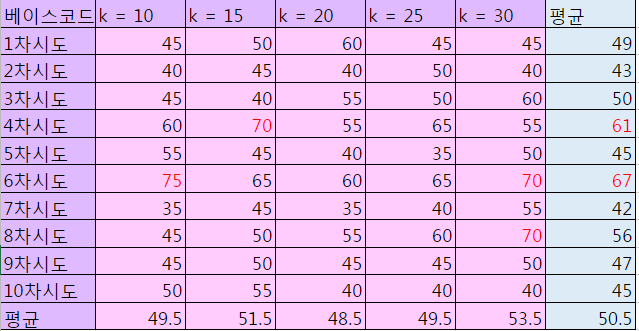

-> 결론적으로 베이스코드를 확인하였을 때 일반적으로 40~70%의 정확도를 보여준다.

- 다른 평가지표로도 확인할 필요가 있음!

# 3. 퍼스널 컬러 분류: Skin Detection + KNN

- 2번 베이스코드와 겹치는 함수는 생략함

## (1) Skin Detection 관련 함수

In [ ]:
def Skin_Detection(img_path):

  #Open a simple image
  img=cv2.imread(img_path)

  #converting from gbr to YCbCr color space
  img_YCrCb = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
  #skin color range for hsv color space
  YCrCb_mask = cv2.inRange(img_YCrCb, (0, 135, 85), (255,180,135))
  YCrCb_mask = cv2.morphologyEx(YCrCb_mask, cv2.MORPH_OPEN, np.ones((3,3), np.uint8))

  YCrCb_result = cv2.bitwise_not(YCrCb_mask)
  YCrCb_skin_detected = cv2.bitwise_and(img, img, mask=YCrCb_mask)

  return img_YCrCb, YCrCb_mask

In [ ]:
# skin 좌표 추출, YCrCb 픽셀값 추출
def coordinate_extraction(mask, img):
  skin = np.argwhere(mask == 255) # mask의 픽셀값이 255인 skin부분의 좌표 추출

  pixel_values = [] # YCbCr 픽셀값 저장을 위한 리스트

  for index in skin:
    y, x = index  #일반적으로 생각하는 가로 x, 세로 y로 표현하기 위해 위치 바꿈
    #print(f"x: {x}, y: {y}") # skin 범위 좌표값 출력(스압주의)
    pixel_value = img[y, x]
    pixel_values.append(pixel_value)

  for coord, pixel_value in zip(skin, pixel_values): # skin부분의 좌표값과 픽셀값 출력을 위한 함수
    x, y = coord
    #print(f"Coordinate: ({x}, {y}), Pixel Value: {pixel_value}")

  return pixel_values

In [ ]:
# 픽셀의 평균값 구하기
def pixel_means(pixel_values):
  # 열 별로 원소들을 더하기
  column_sums = np.sum(pixel_values, axis=0)

  # pixel_values를 NumPy 배열로 변환
  pixel_values = np.array(pixel_values)

  # 열 별로 평균 계산하기
  column_means = column_sums / pixel_values.shape[0]

  return column_means

## (2) 데이터 불러오기 및 데이터 전처리

In [ ]:
def get_dict(dir_path):
  file_list = os.listdir(dir_path)

  img_list = []
  result_list = []

  for file in file_list:
    img_path = os.path.join(dir_path, file)
    if os.path.isdir(img_path):  # 만약 디렉토리인 경우, 무시하고 다음 파일로 넘어감
      continue
    img_YCrCb,YCrCb_mask = Skin_Detection(img_path)
    img_list.append([img_YCrCb, YCrCb_mask]) # 그림 show()를 위한 용도

    # YCrCb
    YCrCb_pixel_values = coordinate_extraction(YCrCb_mask, img_YCrCb)
    YCrCb_pixel_means = pixel_means(YCrCb_pixel_values)
    #print(YCrCb_pixel_means)

    result_list.append(YCrCb_pixel_means)

  return result_list

In [ ]:
path = "/content/drive/MyDrive/four_seasons/사계절_연예인 이미지 데이터셋/prototype/쿨톤_jpg"  # 디렉토리 경로
path2 = "/content/drive/MyDrive/four_seasons/사계절_연예인 이미지 데이터셋/prototype/웜톤_jpg"  # 디렉토리 경로

In [ ]:
cool_result  = get_dict(path) # 1분

In [ ]:
warm_result  = get_dict(path2) # 1분

In [ ]:
images = np.concatenate((cool_result, warm_result), axis=0)

In [ ]:
# labels에 대한 코드
num = len(images)
labels = np.zeros(num)

# 처음 50개의 요소를 1로 변경
labels[length:] = 1

# 0이 쿨톤 1이 웜톤
print(len(images))
print(labels)

100
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1.]


## (3) train, validation, test 데이터 분리하기

In [ ]:
train_ratio = 0.7  # 훈련 세트 비율
val_ratio = 0.2    # 검증 세트 비율
train_data, train_labels, val_data, val_labels, test_data, test_labels = split_data(images, labels, train_ratio, val_ratio)
print("train: ", train_data.shape)
print("val: ", val_data.shape)
print("test: ", test_data.shape)

총 데이터 갯수:  100
총 라벨 갯수:  100
train:  (70, 3)
val:  (20, 3)
test:  (10, 3)


## (4) KNN 실행하기

In [ ]:
# 검증 셋에서 가장 잘 동작하는 hyperparameter 들을 찾는다.
validation_accuracies = []
for k in [10, 15, 20, 25, 30]:

    # 특정 k 값을 정해서 검증 데이터에 대해 평가할 때 사용한다.
    nn = NearestNeighbor()
    nn.train(train_data, train_labels)
    # 여기서는 k를 input으로 받을 수 있도록 변형된 NearestNeighbor 클래스가 있다고 가정하자.
    Yval_predict = nn.predict(val_data, k = k)
    acc = np.mean(Yval_predict == val_labels)
    print('accuracy: %f' % (acc,))

    # 검증 셋에 대한 정확도를 저장해 놓는다.
    validation_accuracies.append((k, acc))

accuracy: 0.550000
accuracy: 0.650000
accuracy: 0.600000
accuracy: 0.600000
accuracy: 0.400000


## (5) 평가하기

In [ ]:
# 이제 본격적인 최고 25개 85% / 정확도 45%~85%정도 나오는듯
print(validation_accuracies)

[(10, 0.55), (15, 0.65), (20, 0.6), (25, 0.6), (30, 0.4)]


In [ ]:
Ytest_predict = nn.predict(test_data, k = k)
print(Ytest_predict)
print(test_labels)

[0. 0. 0. 0. 1. 0. 1. 0. 0. 0.]
[0. 0. 1. 1. 0. 1. 1. 0. 0. 0.]


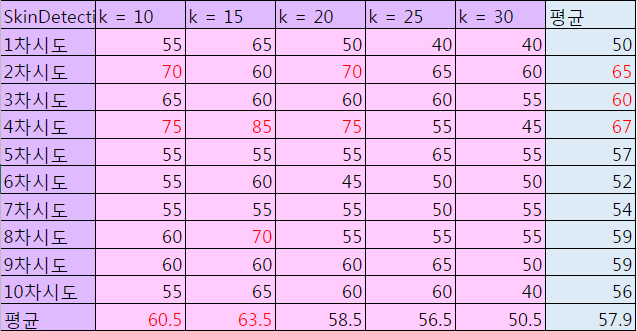  


-> 결론적으로 skin detection을 통하여 추출한 피부 픽셀들의 평균으로 확인하였을 때는 k가 15일 때 85%의 정확도까지 나왔으며 일반적으로 45%~85%사이의 값이 나온다.
- 다른 평가지표와도 비교할 필요가 있다.

# 4. 퍼스널 컬러 분류: Face_Recognition + KNN

## (1) 라이브러리 및 데이터 불러오기

In [118]:
import tensorflow as tf
import numpy as np
import cv2
import os
import glob
from PIL import Image

In [119]:
def load_images_from_directory(directory_path):
    image_paths = glob.glob(directory_path + '/*.jpg')  # 디렉토리 내의 모든 jpg 파일 경로 찾기
    image_paths.extend(glob.glob(directory_path + '/*.jpeg'))  # 디렉토리 내의 모든 jpeg 파일 경로 추가

    images = []
    for image_path in image_paths:
        image = Image.open(image_path)
        image_np = np.array(image)
        images.append(image_np)

    return images

In [120]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [121]:
# 모든 이미지 불러오기
directory_path = "/content/drive/MyDrive/four_seasons/사계절_연예인 이미지 데이터셋/prototype/cropped_face/쿨톤"  # 디렉토리 경로
directory_path2 = "/content/drive/MyDrive/four_seasons/사계절_연예인 이미지 데이터셋/prototype/cropped_face/웜톤"  # 디렉토리 경로
images = load_images_from_directory(directory_path)
images2 = load_images_from_directory(directory_path2)

length = len(images)
print(length)
print(len(images2))

# 이미지 리스트 합치기
images = np.concatenate((images, images2), axis=0)
print(len(images))

50
50
100


<__array_function__ internals>:180: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


## (2) 데이터 전처리

In [122]:
# 새로운 크기로 리사이즈할 이미지의 너비와 높이
new_width = 200
new_height = 200

resized_images = []
for image in images:
    resized_image = cv2.resize(image, (new_width, new_height))
    resized_images.append(resized_image)

# resized_images 리스트를 NumPy 배열로 변환
resized_images_array = np.array(resized_images)

# 변환된 NumPy 배열 출력
print(resized_images_array.shape)

(100, 200, 200, 3)


In [123]:
# 평탄화 작업
images = resized_images_array.reshape(resized_images_array.shape[0], 200 * 200 * 3)

In [124]:
# labels에 대한 코드
num = len(images)
labels = np.zeros(num)

# 처음 50개의 요소를 1로 변경
# 0이 쿨톤 1이 웜톤
labels[length:] = 1

# 0이 쿨톤 1이 웜톤
print(len(images))
print(labels.shape)
print(labels)

100
(100,)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1.]


## (3) train, validation, test 분리하기

In [125]:
def split_data(data, labels, train_ratio, val_ratio):
    # 데이터 개수 확인
    num_examples = len(data)
    num_lables = len(labels)
    print("총 데이터 갯수: ", len(data))
    print("총 라벨 갯수: ", len(labels))

    # 인덱스를 섞은 배열 생성
    shuffled_indices = np.random.permutation(num)

    # 훈련 세트, 검증 세트, 테스트 세트 크기 계산
    train_size = int(num_examples * train_ratio)
    val_size = int(num_examples * val_ratio)
    test_size = num_examples - train_size - val_size

    # 데이터와 레이블을 분할하여 저장할 변수 초기화
    train_data = np.zeros((train_size, *data.shape[1:]))
    train_labels = np.zeros((train_size, *labels.shape[1:]))
    val_data = np.zeros((val_size, *data.shape[1:]))
    val_labels = np.zeros((val_size, *labels.shape[1:]))
    test_data = np.zeros((test_size, *data.shape[1:]))
    test_labels = np.zeros((test_size, *labels.shape[1:]))

    # 데이터와 레이블을 섞은 인덱스를 기반으로 분할
    train_indices = shuffled_indices[:train_size]
    val_indices = shuffled_indices[train_size:train_size+val_size]
    test_indices = shuffled_indices[train_size+val_size:]

    train_data = data[train_indices]
    train_labels = labels[train_indices]
    val_data = data[val_indices]
    val_labels = labels[val_indices]
    test_data = data[test_indices]
    test_labels = labels[test_indices]

    return train_data, train_labels, val_data, val_labels, test_data, test_labels

In [157]:
train_ratio = 0.7  # 훈련 세트 비율
val_ratio = 0.2    # 검증 세트 비율
train_data, train_labels, val_data, val_labels, test_data, test_labels = split_data(images, labels, train_ratio, val_ratio)
print("train: ", train_data.shape)
print("val: ", val_data.shape)
print("test: ", test_data.shape)

총 데이터 갯수:  100
총 라벨 갯수:  100
train:  (70, 120000)
val:  (20, 120000)
test:  (10, 120000)


# (4) KNN

In [127]:
class NearestNeighbor(object):
    def __init__(self):
        pass

    def train(self, X, y):
        """ X is N x D where each row is an example. Y is 1-dimension of size N """
        # nearest neighbor 분류기는 단순히 모든 학습 데이터를 기억해둔다.
        self.Xtr = X
        self.ytr = y

    def predict(self, X, k):
        """ X is N x D where each row is an example we wish to predict label for """
        num_test = X.shape[0]
        # 출력 type과 입력 type이 갖게 되도록 확인해준다.
        Ypred = np.zeros(num_test, dtype = self.ytr.dtype)

    # loop over all test rows
        for i in range(num_test):
        # i번째 테스트 이미지와 가장 가까운 학습 이미지를
            # L1 거리(절대값 차의 총합)를 이용하여 찾는다.
            #distances = np.sum(np.abs(self.Xtr - X[i,:]), axis = 1)
            # L2 거리(직선 거리)를 이용하여 찾는다.
            distances = np.sqrt(np.sum(np.square(self.Xtr - X[i,:]), axis = 1))

            indices = np.argsort(distances)  # 거리가 작은 순서대로 인덱스 정렬
            k_nearest_labels = self.ytr[indices[:k]]  # k개의 가장 가까운 이웃의 라벨
            unique, counts = np.unique(k_nearest_labels, return_counts=True)
            Ypred[i] = unique[np.argmax(counts)]  # 가장 많은 투표를 받은 라벨로 예측
        return Ypred

In [158]:
# 검증 셋에서 가장 잘 동작하는 hyperparameter 들을 찾는다.
validation_accuracies = []
for k in [10, 15, 20, 25, 30]:

    # 특정 k 값을 정해서 검증 데이터에 대해 평가할 때 사용한다.
    nn = NearestNeighbor()
    nn.train(train_data, train_labels)
    # 여기서는 k를 input으로 받을 수 있도록 변형된 NearestNeighbor 클래스가 있다고 가정하자.
    Yval_predict = nn.predict(val_data, k = k)
    acc = np.mean(Yval_predict == val_labels)
    print('accuracy: %f' % (acc,))

    # 검증 셋에 대한 정확도를 저장해 놓는다.
    validation_accuracies.append((k, acc))

accuracy: 0.450000
accuracy: 0.450000
accuracy: 0.400000
accuracy: 0.450000
accuracy: 0.450000


## (5) 평가하기

In [152]:
print(validation_accuracies)

[(10, 0.55), (15, 0.7), (20, 0.55), (25, 0.55), (30, 0.65)]


In [160]:
Ytest_predict = nn.predict(test_data, k = 15)
print(Ytest_predict)
print(test_labels)

[1. 1. 0. 0. 1. 1. 1. 1. 0. 1.]
[0. 0. 1. 0. 0. 1. 0. 1. 0. 0.]


In [155]:
acc = np.mean(Ytest_predict == test_labels)
print(Ytest_predict == test_labels)
print('accuracy: %f' % (acc,))

[ True False False  True  True False  True  True False False]
accuracy: 0.500000


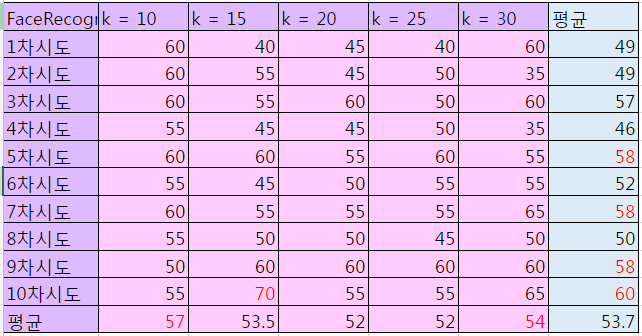

-> face_recognition을 이용하여 얼굴 영역만 추출한 사진으로 KNN을 실행하였을 때 최고로 10차 시도에서 70%까지 나왔으며 일반적으로 40%~65%정도 나온다.
- 다른 평가지표와도 비교할 필요성 있음

# 5. Gradio에 KNN 결합하기

In [156]:
!pip3 install gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.8/19.8 MB 39.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.7/65.7 kB 6.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288.8/288.8 kB 27.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.4/75.4 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 28.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.5/50.5 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.7/138.7 kB 16.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 12.5 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of mdit-py-plugins to determine which version is compatible with other requirements. This could take a while.
  

In [ ]:
# 라이브러리 블러오기

import tensorflow as tf
import numpy as np
import glob
from PIL import Image

In [ ]:
# 데이터 불러오기

def load_images_from_directory(directory_path):
    image_paths = glob.glob(directory_path + '/*.jpg')  # 디렉토리 내의 모든 jpg 파일 경로 찾기
    image_paths.extend(glob.glob(directory_path + '/*.jpeg'))

    images = []
    for image_path in image_paths:
        image = Image.open(image_path)
        image_np = np.array(image)
        images.append(image_np)

    return images